### Reimplementation of Image Super-Resolution Using Deep Convolutional Network in PyTorch

This notebook is the reimplementation of this [paper](https://arxiv.org/abs/1501.00092)

In [1]:
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF
import numpy as np
import time
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load dataset

In [2]:
class MyDataset(Dataset):
    def __init__(self, file_path):
        self.file = h5py.File(file_path, 'r')
        self.data = self.file['data']
        self.label = self.file['label']
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        image = torch.tensor(self.data[idx], dtype=torch.float32)
        label = torch.tensor(self.label[idx], dtype=torch.float32)
        
        return image, label
    
    def close(self):
        self.file.close()       

Image test size:  torch.Size([3, 33, 33])


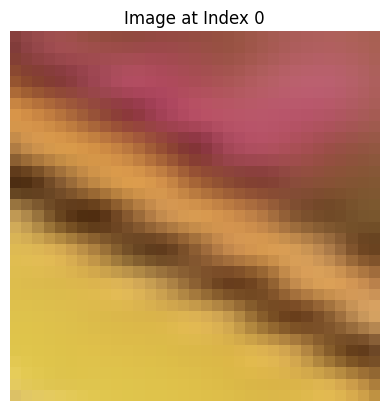

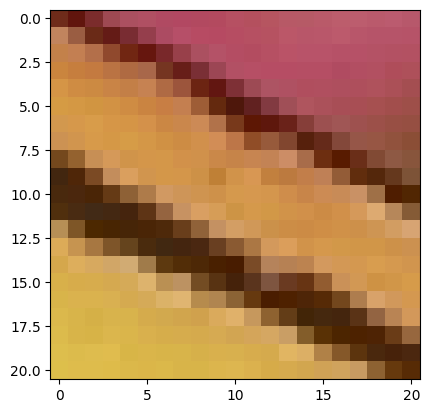

In [3]:
# Create an instance of MyDataset
dataset = MyDataset('train.h5')
test_dataset = MyDataset('test.h5')

# Choose the index of the data point you want to print
index_to_print = 0

# Retrieve the specified data point from the dataset
image, label = dataset[index_to_print]
image_test, label_test = test_dataset[index_to_print]

""" # Convert the image tensor to a PIL image for visualization
pil_image = to_pil_image(image)
pil_label = to_pil_image(label)
# Display the image using Matplotlib
plt.imshow(pil_image)
plt.title(f"Image at Index {index_to_print}")
plt.axis('off')  # Hide axes
plt.show()

# Print information about the label
plt.imshow(pil_label) """

print("Image test size: ", image_test.size())
# Convert the image tensor to a PIL image for visualization
pil_image = to_pil_image(image_test)
pil_label = to_pil_image(label_test)
# Display the image using Matplotlib
plt.imshow(pil_image)
plt.title(f"Image at Index {index_to_print}")
plt.axis('off')  # Hide axes
plt.show()

# Print information about the label
""" print(f"Label at Index {index_to_print}: {label}") """
plt.imshow(pil_label)


# Close the dataset (important for releasing resources)
dataset.close()

### Preparing Datasets and Dataloaders

The train.h5 and test.h5 files are obtained by running the MATLAB scripts generate_train and generate_test respectively from [this](https://mmlab.ie.cuhk.edu.hk/projects/SRCNN/SRCNN_train.zip) source code given in the original paper

In [4]:
# Define dataset and dataloader
dataset = MyDataset('train.h5') 
train_loader = DataLoader(dataset, batch_size=128)

dataset_test_set5 = MyDataset('test.h5')
val_loader = DataLoader(dataset_test_set5, batch_size=128)

### Defining the CNN model

In [5]:
# Define the SRCNN model
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=0)  # Changed input channels to 1
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, stride=1, padding=0)  # Changed output channels to 1
        
        self._initialize_weights()

    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))
        out = self.conv3(out)
        # Resize output to match labels dimensions (21, 21)
        #out = F.interpolate(out, size=(21, 21), mode='bicubic', antialias=False)
        return out
    
    def _initialize_weights(self):
        # Initialize weights with Gaussian distribution (std=0.001) and bias with zeros
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Initialize convolutional layer weights with Gaussian distribution (std=0.001)
                nn.init.normal_(m.weight, mean=0, std=0.001)
                if m.bias is not None:
                    # Initialize bias with zeros
                    nn.init.constant_(m.bias, 0)

model = SRCNN()

### Defining hyperparameters

In [34]:
# Define different learning rates and multipliers for weights and biases
learning_rates = {
    'conv1_weight': 1e-4 * 1.0,
    'conv1_bias': 1e-4  * 0.1,
    'conv2_weight': 1e-4 * 1.0,
    'conv2_bias': 1e-4 * 0.1,
    'conv3_weight': 1e-5 * 0.1,
    'conv3_bias': 1e-5 * 0.1 
}

# Group parameters and assign specific learning rates with multipliers
param_groups = []
for name, param in model.named_parameters():
    if name in learning_rates:
        lr = learning_rates[name]
    else:
        lr = 0.001  # Default learning rate for other parameters

    param_groups.append({'params': param, 'lr': lr})

#optimizer = optim.SGD(param_groups, lr=0.0001)
#optimizer = optim.SGD(param_groups, lr=0.001, momentum=0.9,weight_decay=1e-4, nesterov=False)
optimizer = optim.Adam( param_groups,lr=0.000001, weight_decay=1e-4)

criterion = nn.MSELoss()
criterion = criterion.to(device=device)
criterion = nn.SmoothL1Loss()
num_epochs = 10

### Training loop

In [35]:
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        #outputs_resized = torch.nn.functional.interpolate(outputs, size=(21,21), mode='bilinear', align_corners=False)

        #print("Output dimension ", outputs_resized[0].size())
        # Print shapes of outputs and labels
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss after each epoch
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

end_time = time.time()
training_time_baseline = end_time - start_time
print(f"Training completed in {training_time_baseline:.2f} seconds")
# Save the trained model
torch.save(model.state_dict(), 'srcnn_model.pth')

Epoch 1, Loss: 0.0019185011353864171
Epoch 2, Loss: 0.0011362284510944257
Epoch 3, Loss: 0.001124946225215407
Epoch 4, Loss: 0.001122067338677452
Epoch 5, Loss: 0.001111904242390986
Epoch 6, Loss: 0.00110930173233261
Epoch 7, Loss: 0.001105765562833232
Epoch 8, Loss: 0.0011113561936380231
Epoch 9, Loss: 0.0010923107808647567
Epoch 10, Loss: 0.0011063256437945014
Training completed in 189.27 seconds


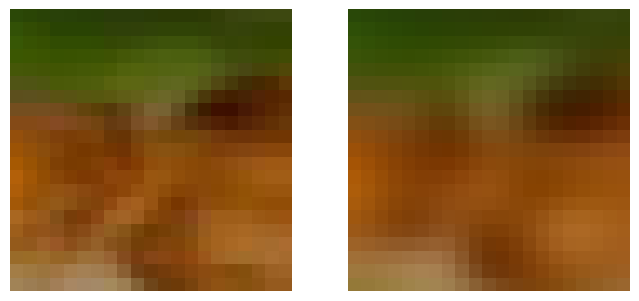

Validation Loss: 0.0005552052680286579


In [38]:
#Evaluate model on validation dataset
model.eval()
val_loss = 0.0
for batch_idx, (val_inputs, val_labels) in enumerate(val_loader):
    val_outputs = model(val_inputs)
    #val_outputs = torch.nn.functional.interpolate(outputs, size=(21,21), mode='bilinear', align_corners=False)
    """ print(val_labels[0])
    print(val_outputs[0]) """
    
    val_loss += criterion(val_outputs, val_labels).item()

index_to_print = 5

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(val_labels[index_to_print]))
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(to_pil_image(val_outputs[index_to_print]))
plt.axis('off')

plt.show()

average_val_loss = val_loss / len(val_loader)
print(f"Validation Loss: {average_val_loss}")

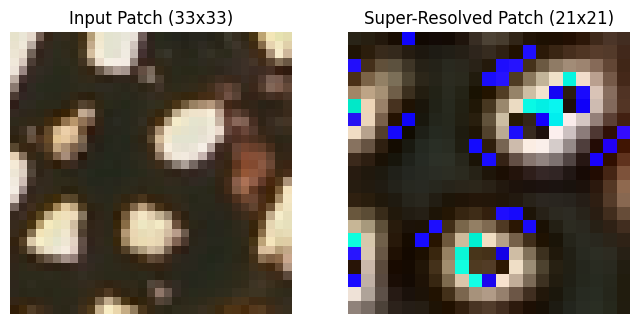

In [43]:
import torch
import matplotlib.pyplot as plt

# Load the input image
input_image_path = 'butterfly_GT.bmp'
input_image = Image.open(input_image_path).convert('RGB')

# Define patch size and stride
input_patch_size = 33
output_patch_size = 21
stride = 14
stride = 10

# Extract patches from the input image
patches = []
image_width, image_height = input_image.size

for y in range(0, image_height - input_patch_size + 1, stride):
    for x in range(0, image_width - input_patch_size + 1, stride):
        # Crop input patch from the image
        input_patch = input_image.crop((x, y, x + input_patch_size, y + input_patch_size))
        input_patch_tensor = TF.to_tensor(input_patch)  # Convert patch to tensor (RGB format)
        patches.append(input_patch_tensor)

# Convert list of tensors to a batch tensor
input_batch = torch.stack(patches)

# Initialize and load the trained SRCNN model
model = SRCNN()
model.load_state_dict(torch.load('srcnn_model.pth'))
model.eval()

# Perform inference on the input patches using the model
with torch.no_grad():
    output_batch = model(input_batch)

# Visualize and evaluate a specific output patch
patch_index = 69  # Example patch index to visualize

# Convert output patch tensor to a PIL image
output_patch_tensor = output_batch[patch_index].detach().cpu()
output_patch_pil = TF.to_pil_image(output_patch_tensor)

# Display the input patch and the model's output (super-resolved patch)
plt.figure(figsize=(8, 4))

# Display input patch
plt.subplot(1, 2, 1)
input_patch_pil = TF.to_pil_image(input_batch[patch_index].detach().cpu())
plt.imshow(input_patch_pil)
plt.title('Input Patch (33x33)')
plt.axis('off')

# Display output patch (super-resolved)
plt.subplot(1, 2, 2)
plt.imshow(output_patch_pil)
plt.title('Super-Resolved Patch (21x21)')
plt.axis('off')

plt.show()


### Calculating PSNR values for validation images

In [ ]:
# Function to calculate PSNR between two images
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')  # PSNR is infinite if images are identical
    MAX = 255.0
    psnr = 10 * np.log10((MAX**2) / mse)
    return psnr

In [ ]:
# Initialize list to store PSNR values
psnr_values = []

# Iterate over validation loader
for inputs, labels in val_loader:
    # Move inputs and labels to the device
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # Generate predictions using the model
    with torch.no_grad():
        outputs = model(inputs)
        
    
    # Convert tensors to numpy arrays (RGB images)
    outputs = outputs.cpu().detach().numpy()  # Convert model outputs to numpy arrays
    print(outputs[0])
    labels = labels.cpu().detach().numpy()  # Convert labels to numpy arrays
    
    output = to_pil_image(outputs.squeeze().cpu().numpy() )
    plt.subplot(1, 2, 2)
    plt.imshow(output)
    plt.title('Model Prediction')
    plt.axis('off')
    
    
    # Calculate PSNR for each image pair in the batch
    for i in range(outputs.shape[0]):  # Iterate over batch size
        psnr_value = calculate_psnr(outputs[i].transpose(1, 2, 0), labels[i].transpose(1, 2, 0))  # Calculate PSNR for RGB images
        psnr_values.append(psnr_value)

# Compute average PSNR over all images in the dataset
average_psnr = np.mean(psnr_values)
print(f"Average PSNR: {average_psnr:.2f} dB")

### Testing the model using test images

In [ ]:
# Create DataLoader for test dataset
test_dataset = MyDataset('test.h5')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Use batch_size=1 for inference

# Load your trained SRCNN model
model = SRCNN()  # Assuming you have defined your SRCNN model class
model.load_state_dict(torch.load('srcnn_model.pth'))
model.eval()

# Choose the index of the patch to visualize (e.g., the first patch)
patch_index = 2  # Change this index to visualize a different patch

# Iterate through the test_loader to extract the specified patch
with torch.no_grad():
    for idx, (input_patch, label_patch) in enumerate(test_loader):
        if idx == patch_index:
            print(input_patch[idx])
            # Perform inference on the input patch
            output_tensor = model(input_patch)  # Forward pass through the model
            print("Output tensor: ", output_tensor)
            output_patch = output_tensor.squeeze().cpu().numpy()  # Convert model output to numpy array
            
            # Convert input and output patches to PIL images for visualization
            input_pil = to_pil_image(input_patch)  # Convert input patch to PIL image
            output_pil = to_pil_image(output_patch)  # Convert output patch to PIL image
            
            # Display the input patch and the model's output
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(input_pil)
            plt.title('Input Patch')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(output_pil)
            plt.title('Model Prediction')
            plt.axis('off')
            
            plt.show()
            break  # Stop iterating after visualizing the specified patch
